# Import and Setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q "tmtoolkit[recommended, lda]"

In [ ]:
import warnings
import pandas as pd
import numpy as np
import random
import gzip
import json
import pickle

from tmtoolkit.topicmod.visualize import generate_wordclouds_for_topic_words
from textblob import TextBlob
from collections import Counter

SEED = 2004
random.seed(SEED)
np.set_printoptions(precision=5)
warnings.filterwarnings("ignore")

DIR = 'drive/MyDrive/dtsa5799_product_review_topic_model'
DATA_DIR = '%s/data' % DIR
META_PATH = f'{DATA_DIR}/meta_Clothing_Shoes_and_Jewelry.jsonl.gz'

# Topic Reviews

In [ ]:
# load
doc_clas_path = f'{DATA_DIR}/doc_clas_24_1_1.csv'
doc_clas = pd.read_csv(doc_clas_path)

In [ ]:
# create column 'rank'
doc_clas['rank'] = doc_clas['rank_1'].str.split(' \(').str[0]
doc_clas.head()

,document,rank_1,rank_2,text,rank
0,B0000V9K32.A3BVWMS9I8OH8U,2_size_small_order (0.4583),21_watch_band_wrist (0.4583),the colour i received is not blue as shown but...,2_size_small_order
1,B0000V9K32.ACT5DY536GISV,22_black_white_color (0.5744),20_love_gift_son (0.3601),Very cute and is really practical. Fits better...,22_black_white_color
2,B0000V9KRI.A1BEBWGPSB2DLM,23_shirt_short_sunglass (0.7042),10_shoe_run_free (0.2042),"good price, very good material and excellent d...",23_shirt_short_sunglass
3,B0000V9KRI.A1EDPEDXSQ78G4,21_watch_band_wrist (0.5868),12_boot_work_day (0.1701),"I mean, Roxy rocks, but I'm kinda dissapointed...",21_watch_band_wrist
4,B0000V9KRI.AR7L2ZP173QEE,11_good_quality_product (0.7724),21_watch_band_wrist (0.1571),"I love this watch, i use every day, every wher...",11_good_quality_product


## topic clouds & sentiments

extract information

In [ ]:
# load the model
model_path = f'{DATA_DIR}/model_24_1_1.p'
with open(model_path, 'rb') as file:
    model_data = pickle.load(file)
    model = model_data['model']
    vocab = model_data['vocab']
    # doc_labels = model_data['doc_labels']
    # dtm = model_data['dtm']

# load the topic labels
topic_labels_path = f'{DATA_DIR}/topic_labels_24_1_1.p'
with open(topic_labels_path, 'rb') as file:
    topic_labels = pickle.load(file)


In [ ]:
topic_clouds = generate_wordclouds_for_topic_words(model.topic_word_,
                                                   vocab,
                                                   top_n=20,
                                                   topic_labels=topic_labels,
                                                   width=400,
                                                   height=300)
topic_clouds.keys()

dict_keys(['1_play_basketball_cleat', '2_size_small_order', '3_sock_sandal_foot', '4_shoe_great_gym', '5_foot_shoe_support', '6_store_find_buy', '7_wide_foot_size', '8_great_arrive_thank', '9_shoe_feel_walk', '10_shoe_run_free', '11_good_quality_product', '12_boot_work_day', '13_run_shoe_mile', '14_shoe_month_squeak', '15_muy_que_los', '16_pair_comfortable_wear', '17_air_nike_max', '18_return_order_pay', '19_bag_gym_pocket', '20_love_gift_son', '21_watch_band_wrist', '22_black_white_color', '23_shirt_short_sunglass', '24_color_love_shoe'])

In [ ]:
# load meta_data = {asin: title}
with gzip.open(META_PATH, 'rt') as f:
    meta_data = {
        json.loads(line)['asin']: json.loads(line)['title']
        for line in f
        if 'asin' in json.loads(line) and 'title' in json.loads(line)}

## top products in topic group

In the selected topic group, we can filter for the top three most mentioned products and inspect the corresponding reviews.

For example:

In [ ]:
def print_topic_reviews(df, topic, n_reviews=8):
    display(topic_clouds[topic])

    re_group = df[df['rank'] == topic]
    top_asins = Counter(re_group['document'].apply(lambda x: x.split('.')[0])).most_common(3)
    print("\nTop Products in Topic '{}'".format(topic))

    for asin, _ in top_asins:
        print(f"\nASIN: {asin}, Title: {meta_data.get(asin, 'Title not found')}")
        asin_reviews = re_group[re_group['document'].str.startswith(asin)]
        sampled_reviews = asin_reviews.sample(n=min(n_reviews, len(asin_reviews))) if len(asin_reviews) > 0 else []

        pos_texts, neg_texts = [], []
        for _, row in sampled_reviews.iterrows():
            sentiment = TextBlob(row['text']).sentiment.polarity
            if sentiment > 0:
                pos_texts.append(row['text'])
            elif sentiment < 0:
                neg_texts.append(row['text'])

        print(f"\nPositive Sentiment Reviews:")
        for i, text in enumerate(pos_texts):
            print(f"{i}: {text}")
        print(f"\nNegative Sentiment Reviews:")
        for i, text in enumerate(neg_texts):
            print(f"{i}: {text}")
        print("------------------------------")


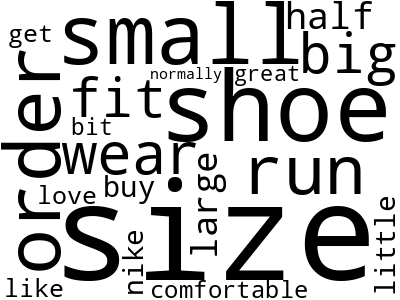

Top Products in Topic '2_size_small_order'

ASIN: B003HD6KY2, Title: Nike Free 5.0 Womens Running Shoes

Positive Sentiment Reviews:
0: I'm a fan of shoes and Nike is one of the best out there love the color and the comfort.
1: Awsome shoes they fit perfectly best shoe I have ever brought I recommed that u buy this shoe !!!!--- !!!
2: Neon Yellow..good shoe..would buy again. Just know you should buy .5 sizes bigger. Not saying this is a premier Nike shoe.. but it's good enough for what i paid for it.
3: It fits perfectly. The shoes are great, it fits perfectly and they are great! The color, the material and the fit is perfect!
4: great shoes at great price
5: Excellent shoes!  Very comfortable and lightweight, feels like I'm not even wearing shoes.  Would most definitely recommend them to everyone.
6: These shoes fit snug and secure as I had hoped! Nike always runs a half shoe size smaller than I normally wear so I always go up half a size. Normally I wear an 8 but I ordered the 8.5 an

In [ ]:
print_topic_reviews(doc_clas, "2_size_small_order")

| Topic: 2_size_small_order | Issue | Recommendations |
|------------------------|--------|-----------------|
| - Nike Free 5.0 Womens Running Shoes<br>- Nike Men's Benassi Swoosh Slide Sandal<br>- Nike Free 5.0+ Mens Running Shoes 579959-740 | - Shoe sizes run small | ✓ Re-evaluate and standardize sizing information<br>✓ Provide customer purchase consultation<br>✓ Provide convenient return/exchange policies |


In the topic group '2_size_small_order', the top three most reviewed products are "Nike Free 5.0 Womens Running Shoes", "Nike Men's Benassi Swoosh Slide Sandal", and "Nike Free 5.0+ Mens Running Shoes 579959-740".

The majority of consumers report that the shoe sizes run small, necessitating the purchase of a size larger than usual. Therefore, it is recommended to re-evaluate and standardize the sizing information for the shoes to ensure that consumers can select the appropriate size based on their actual measurements, reducing returns and exchanges due to sizing issues.

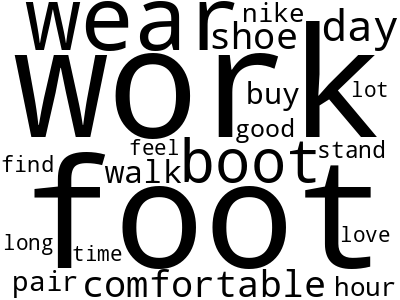


Top Products in Topic '12_boot_work_day'

ASIN: B001E4X1T8, Title: Nike Air Max Goadome Mens

Positive Sentiment Reviews:
0: Bought these boots from a store in the mall, they are awesome boots,comfortable lightweight,and waterproof. My only complaint is the color wore off them on the front top of shoe just below the laces. It kinda turned gray greenish color but in all fairness I wore them in the snow and rain at work. I'm looking to replace them with the same boots again.
1: Best work boot EVER!BACKGROUNDI started wearing Nike's in high school in 1989. After that I wore various other Nike sneakers for work shoes since 1994.About 2 and a half years ago or so I developed chronic foot pain, also known as plantar fasciitis.As a result of this I began wearing the Nike Air MAX 90, (which were the most comfortable Nike's I could find) for my work shoes for the last year and a half.I also began wearing Pinnacle Prostep insoles along with the Air Max 90. This combination along with wool (thic

In [ ]:
print_topic_reviews(doc_clas, '12_boot_work_day')

| Topic: 12_boot_work_day | Features | Issues | Recommendations |
|-------------------------------|------------------|------------------|-----------------|
| ➤ Nike Air Max Goadome Mens<br>➤ Nike Air Monarch IV Men's Cross Training Shoes<br>➤ Nike Air Max Goadome 2013 Mens  | - Suitable for long-term wear<br>- Sturdy as work shoes | - Color wear<br>- Noise from the soles | ✓ Increase waterproofing and durability<br>✓ Strengthen quality control<br>✓ Provide after-sales repair services |


In the '12_boot_work_day' topic group, the top three most reviewed products are "Nike Air Max Goadome Mens," "Nike Air Monarch IV Men's Cross Training Shoes," and "Nike Air Max Goadome 2013 Mens."

These three products are considered by consumers to be suitable for long-term wear and sturdy as work shoes. Some consumers have expressed a desire for further improvement in quality, such as color wear and noise from the soles.

Given the intended use by the target group, it is recommended to increase the waterproofing, durability, and comfort of the shoes, and to strengthen quality control measures. Providing after-sales repair services could also be considered.

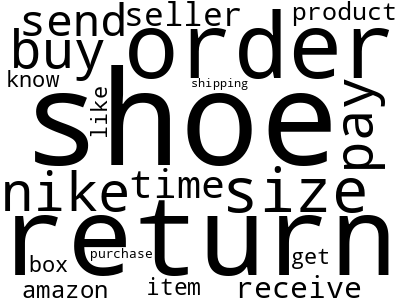


Top Products in Topic '18_return_order_pay'

ASIN: B00310WE0U, Title: Nike Men's Air Jordan 11 Retro Basketball Shoe

Positive Sentiment Reviews:
0: OMG, THIS SHOE IS EVERYTHING THAT I EXPECTED!  THIS IS MY FIRST PAIR OF JORDANS AND I LOVE IT!!!!!!!!!!!!!!!!!!!!!!!!!!!!  AT FIRST I THOUGHT THAT THE PRICE WAS A BIT HIGH, BUT ITS WORTH EVERY PENNY!  I AM HAPPY THAT I MADE THIS INVESTMENT.  AFTER BUYING THESE, I THINK I WILL BECOME A JORDAN'S FANATIC!!!!!!!!!!!!!!!!!!!!!!!!!!!!
1: Item was great except for the paper inside the box was destroyed & the grey 11 plastic cover was cracked! I don't know how such a thing could happen other than the people not taking care of em. Shoes are icy and it was a good cop
2: I purchased my gamma 11's from kickzstore and they were prefect! 100% authentic shoes and the service was great! I was skeptical at first with the price an all! But I'm very satisfied!
3: This company attempted to sell me counterfeit Air Jordan 11 Concords.  Here are some of the iss

In [ ]:
print_topic_reviews(doc_clas, '18_return_order_pay')

| Topic: 18_return_order_pay                                         | Features/Issues                                        | Recommendations                                                       |
|------------------------------------------------|--------------------------------------------------------|-----------------------------------------------------------------------|
| ➤ Nike Men's Air Jordan 11 Retro Basketball Shoe | - Counterfeit or defective items<br>- Dissatisfaction with shipping and packaging | ✓ Enhance quality control measures to prevent counterfeit products from entering the market<br>✓ Improve packaging materials to ensure products are not damaged during shipping |
| ➤ Nike Air Monarch IV Men's Cross Training Shoes | - Comfortable and durable<br>- Noise issue from the soles | ✓ Address the noise issue immediately and provide after-sales repair services |
| ➤ Nike Men's Benassi Swoosh Slide Sandal         | - Shoes are too narrow, leading to exchanges or returns | ✓ Re-evaluate the standard sizing of the shoes or expand the range of product sizes |


In the topic group '18_return_order_pay', the top three mentioned products have various issues that require returns.

For the product "Nike Men's Air Jordan 11 Retro Basketball Shoe", some consumers received counterfeit or defective items and expressed dissatisfaction with shipping and packaging issues, affecting their trust in the brand.

It is recommended to ensure quality control and prevent counterfeit products from entering the market. Additionally, improve packaging materials to ensure products are not damaged during shipping.

The product "Nike Air Monarch IV Men's Cross Training Shoes" is comfortable and durable, but many consumers have reported noise issues. It is suggested to address these issues immediately or provide repair services.

For the product "Nike Men's Benassi Swoosh Slide Sandal", some consumers reported that the shoes were too narrow and had to be exchanged or returned. It is recommended to re-evaluate the standard sizing of the shoes or expand the range of product sizes.

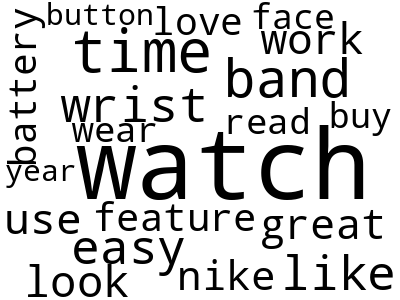


Top Products in Topic '21_watch_band_wrist'

ASIN: B000E8H01K, Title: Nike Men's C0021-001 Hammer Watch

Positive Sentiment Reviews:
0: My wife purchased this watch for me as a b/day present, i was at first a little baffled by the design, but it is a great item to have as a rugged everyday time piece.The numbers are big and large for those who cant see well and is water resistant just in case you forget it on while you go swimming.I give it 4 stars for its features,quality,design and price.
1: Great watch, great price.  This is an awesome watch for weekend wear and sporting activities.  It is a little big, but draws attention.
2: The Nike Hammer is well designed and finish is excellent. The controls are intuitive.  I did not receive a manual with the watch, so there are still some aspects of the watch I have not discovered.  The only negative for me is that the band is VERY wide, so it is great for working out and bike riding, and not so great for use with long sleeve shirts. Also the

In [ ]:
print_topic_reviews(doc_clas, '21_watch_band_wrist')

| Topic: 21_watch_band_wrist | Positive | Negative | Recommendations |
|------------------------|----------|----------|-----------------|
| ➤ Nike Men's C0021-001 Hammer Watch<br>➤ Nike Unisex Watch WR0139-021<br>➤ Nike Midsize WR0127-001 Triax Speed 100 Super Watch | - Large watch face<br> - Easy-to-read fonts | - Too large and heavy<br>- Unsuitable for smaller wrists<br>- Watchbands need better material and durability | ✓ Offer more size options for different wrist sizes<br>✓ Use lighter, more durable materials to reduce watch weight<br>✓ Improve watchband material for easier cleaning and durability<br>✓ Provide convenient return/exchange policies and after-sales services |


In the topic group '21_watch_band_wrist', the most reviewed products are the "Nike Men's C0021-001 Hammer Watch," "Nike Unisex Watch WR0139-021," and the "Nike Midsize WR0127-001 Triax Speed 100 Super Watch."

Consumers are very satisfied with the large watch face and easy-to-read fonts. However, many consumers have reported that the watches are large and heavy, making them unsuitable for those with smaller wrists. The material and durability of the watchbands also need improvement.

It is recommended to diversify the product line by offering more size options to cater to different genders and wrist sizes. Consider reducing the weight of the watches by using lighter and more durable materials. Improve the watchband material to make it easier to clean and more durable. Additionally, consider providing convenient return and exchange policies and after-sales services, such as battery and watchband replacements.